In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from sklearn.datasets import fetch_mldata
from sklearn.preprocessing import LabelBinarizer
import sklearn.metrics as sm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Подготовка данных: 
загрузим датасет mnist, случайным образом перемешаем, бинаризуем истинные метки объектов и разделим выборку на тренировочную, валидационную и тестовую.

In [2]:
mnist=fetch_mldata(dataname='MNIST original',data_home='mnist')
X,T = mnist['data'],mnist['target']
p = np.random.permutation(X.shape[0])

lb = LabelBinarizer()
X,T = X[p],lb.fit_transform(T[p])

X_train, T_train = X[:50000]/255.,T[:50000]
X_val,T_val = X[50000:60000]/255.,T[50000:60000]
X_test,T_test = X[60000:]/255.,T[60000:]


### Тренировка сети:

Будем использовать следующую структуру сети: Линейный слой(50) -> Тангенциальный слой-> Линейный слой(10) -> Softmax -> NLL.


В линейном слое используется L2-регуляризация

In [3]:
import nn
reload(nn)

<module 'nn' from 'nn/__init__.pyc'>

In [4]:
NN = nn.sequential.Sequential()
NN.add(nn.linear.Linear(784,50,learning_rate=1e-3,lmbda=5e-4))
NN.add(nn.tanh.Tanh())
NN.add(nn.linear.Linear(50,10,learning_rate=1e-3,lmbda=5e-4))
NN.add(nn.softmax.SoftMax())
NN.add(nn.NLL())
print("Current architecture")
NN.added_layers()

Current architecture
Linear_(in=784,out=50)_1
Tanh_1
Linear_(in=50,out=10)_2
SoftMax_1
NLL_1


In [5]:
batch_size = 250
l_epoch = []
l_val = []
accuracies = []
n_epochs = 30

for i in tqdm.tqdm(xrange(n_epochs)):
    p = np.random.permutation(X_train.shape[0])
    X_train, T_train = X_train[p],T_train[p]
    losses = []
    l_val.append((1./X_val.shape[0])*NN.forward(X_val,T_val))
    
    for batch_data,batch_label in zip(np.array_split(X_train,X_train.shape[0]//batch_size),
                                        np.array_split(T_train,T_train.shape[0]//batch_size)):
        losses.append(NN.forward(batch_data,Y=batch_label))
        NN.backward()
    l_epoch.append((1./X_train.shape[0])*np.sum(losses))    
    y_pred = NN.predict(X_val)
    accuracies.append(sm.accuracy_score(T_val,y_pred))
    

100%|██████████| 30/30 [01:01<00:00,  2.42s/it]


### Анализ тренировки:

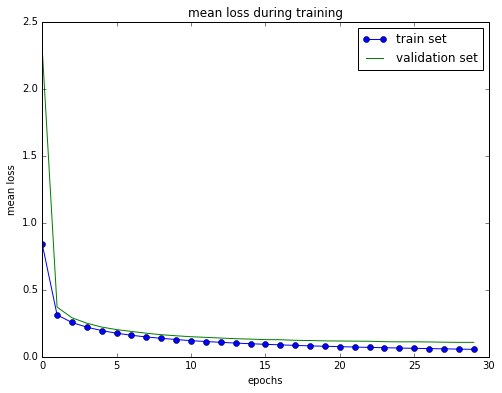

In [6]:
plt.figure(figsize = (8,6))
plt.plot(l_epoch,'o-',label='train set')
plt.plot(l_val,label='validation set')
plt.xlabel('epochs')
plt.ylabel('mean loss')
plt.legend()
plt.title('mean loss during training')
plt.savefig('loss.png')

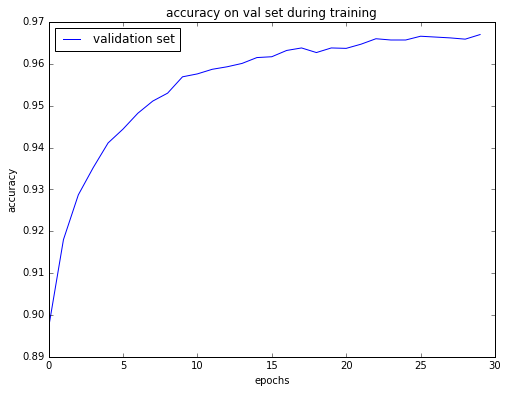

In [7]:
plt.figure(figsize = (8,6))
plt.plot(accuracies,'-',label='validation set')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.title('accuracy on val set during training')
plt.savefig('accuracy.png')

Предскажем метки классов для тестовой выборки, оценим среднюю точность

In [8]:
y_pred_test = NN.predict(X_test)
print "Accuracy on test set", sm.accuracy_score(T_test,y_pred_test)

Accuracy on test set 0.9689
